# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print(azdias.shape)
azdias.head()

(891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [5]:
print(feat_info.shape)
feat_info.head()

(85, 4)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
# Identify missing or unknown data values and convert them to NaNs.
for index, row in feat_info.iterrows():
    feature_name = row['attribute']
    temp_str = row['missing_or_unknown'].strip('[] ')
    temp_list = []
    if temp_str:
        temp_list = temp_str.split(',')
    missing_or_unknown_list = [ int(val.strip()) if val.strip(' -').isdigit() else val.strip() for val in temp_list ]
    if missing_or_unknown_list:
        azdias.loc[azdias[feature_name].isin(missing_or_unknown_list), feature_name] = np.nan
        #azdias.loc[:,feature_name].replace(to_replace=missing_or_unknown_list, value=np.nan, inplace=True)


In [7]:
azdias.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2.0,5.0,1.0,5.0,1.0,5.0,4.0,3.0,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1.0,3.0,3.0,3.0,4.0,1.0,3.0,2.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1.0,3.0,4.0,4.0,2.0,4.0,2.0,2.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2.0,4.0,2.0,4.0,2.0,3.0,5.0,4.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [8]:
# Perform an assessment of how much missing data there is in each column of the dataset.
nan_counts_per_column = azdias.isnull().sum()
#nan_counts_per_column = azdias.shape[0] - azdias.count()
print(nan_counts_per_column)

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

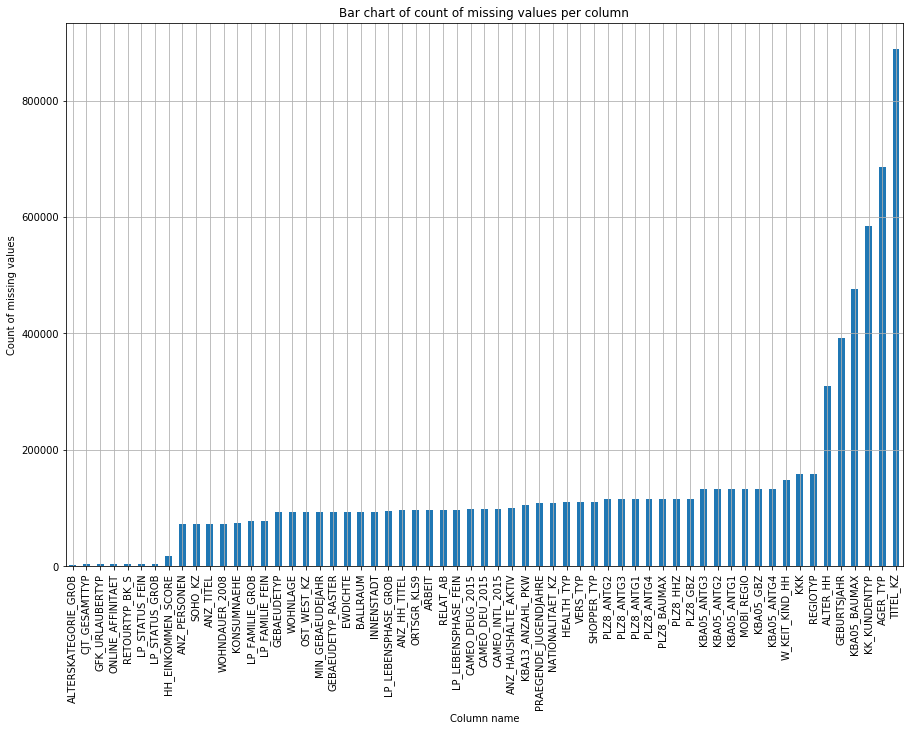

In [9]:
# Investigate patterns in the amount of missing data in each column.
columns_with_nan = nan_counts_per_column[nan_counts_per_column > 0]
columns_with_nan.sort_values(inplace=True)

columns_with_nan.plot.bar(figsize=(15, 10))
plt.xlabel('Column name')
plt.ylabel('Count of missing values')
plt.grid(True)
plt.title('Bar chart of count of missing values per column')
plt.show()


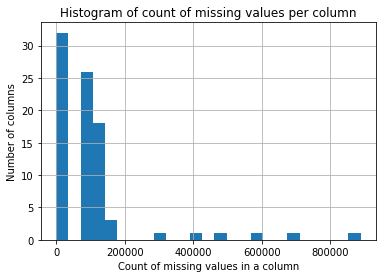

In [10]:
plt.hist(nan_counts_per_column, bins=25)
plt.xlabel('Count of missing values in a column')
plt.ylabel('Number of columns')
plt.title('Histogram of count of missing values per column')
plt.grid(True)
plt.show()

In [11]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
outlier_columns = nan_counts_per_column[nan_counts_per_column > 200000]
print(outlier_columns)

AGER_TYP        685843
GEBURTSJAHR     392318
TITEL_KZ        889061
ALTER_HH        310267
KK_KUNDENTYP    584612
KBA05_BAUMAX    476524
dtype: int64


In [12]:
azdias.drop(outlier_columns.index, axis=1, inplace=True)

#### Discussion 1.1.2: Assess Missing Data in Each Column

As we can observe from the bar plot and histogram, there are only 6 columns in the dataset which contain more than 200000 missing values. Clearly, these 6 columns can be considered as outliers and dropped from the dataframe.

The columns removed from the dataset are:

- AGER_TYP
- GEBURTSJAHR
- TITEL_KZ
- ALTER_HH
- KK_KUNDENTYP
- KBA05_BAUMAX

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [13]:
# How much data is missing in each row of the dataset?
nan_counts_per_row = azdias.isnull().sum(axis=1)
#nan_counts_per_row = azdias.shape[1] - azdias.count(axis=1)

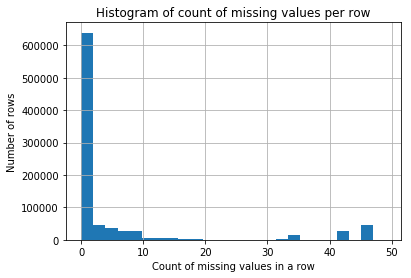

In [14]:
plt.hist(nan_counts_per_row, bins=25)
plt.xlabel('Count of missing values in a row')
plt.ylabel('Number of rows')
plt.title('Histogram of count of missing values per row')
plt.grid(True)
plt.show()

In [15]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
print(azdias.shape)
low_nan_subset = azdias[nan_counts_per_row <= 20]
print(low_nan_subset.shape)
high_nan_subset = azdias[nan_counts_per_row > 20]
print(high_nan_subset.shape)

(891221, 79)
(797426, 79)
(93795, 79)


In [16]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
columns_without_nan = nan_counts_per_column[nan_counts_per_column == 0]
print("Columns without missing values:")
print(columns_without_nan)

Columns without missing values:
ANREDE_KZ                0
FINANZ_MINIMALIST        0
FINANZ_SPARER            0
FINANZ_VORSORGER         0
FINANZ_ANLEGER           0
FINANZ_UNAUFFAELLIGER    0
FINANZ_HAUSBAUER         0
FINANZTYP                0
GREEN_AVANTGARDE         0
SEMIO_SOZ                0
SEMIO_FAM                0
SEMIO_REL                0
SEMIO_MAT                0
SEMIO_VERT               0
SEMIO_LUST               0
SEMIO_ERL                0
SEMIO_KULT               0
SEMIO_RAT                0
SEMIO_KRIT               0
SEMIO_DOM                0
SEMIO_KAEM               0
SEMIO_PFLICHT            0
SEMIO_TRADV              0
ZABEOTYP                 0
dtype: int64


In [17]:
def compare_plots(columns):
    fig, axes = plt.subplots(nrows=len(columns), ncols=2, figsize=(15,30))
    axes[0,0].set_title('Distribution in dataset with <= 20 missing values per row')
    axes[0,1].set_title('Distribution in dataset with > 20 missing values per row')
    n=0
    for column_name in columns:
        sns.countplot(low_nan_subset[column_name], ax=axes[n,0])
        sns.countplot(high_nan_subset[column_name], ax=axes[n,1])
        n+=1

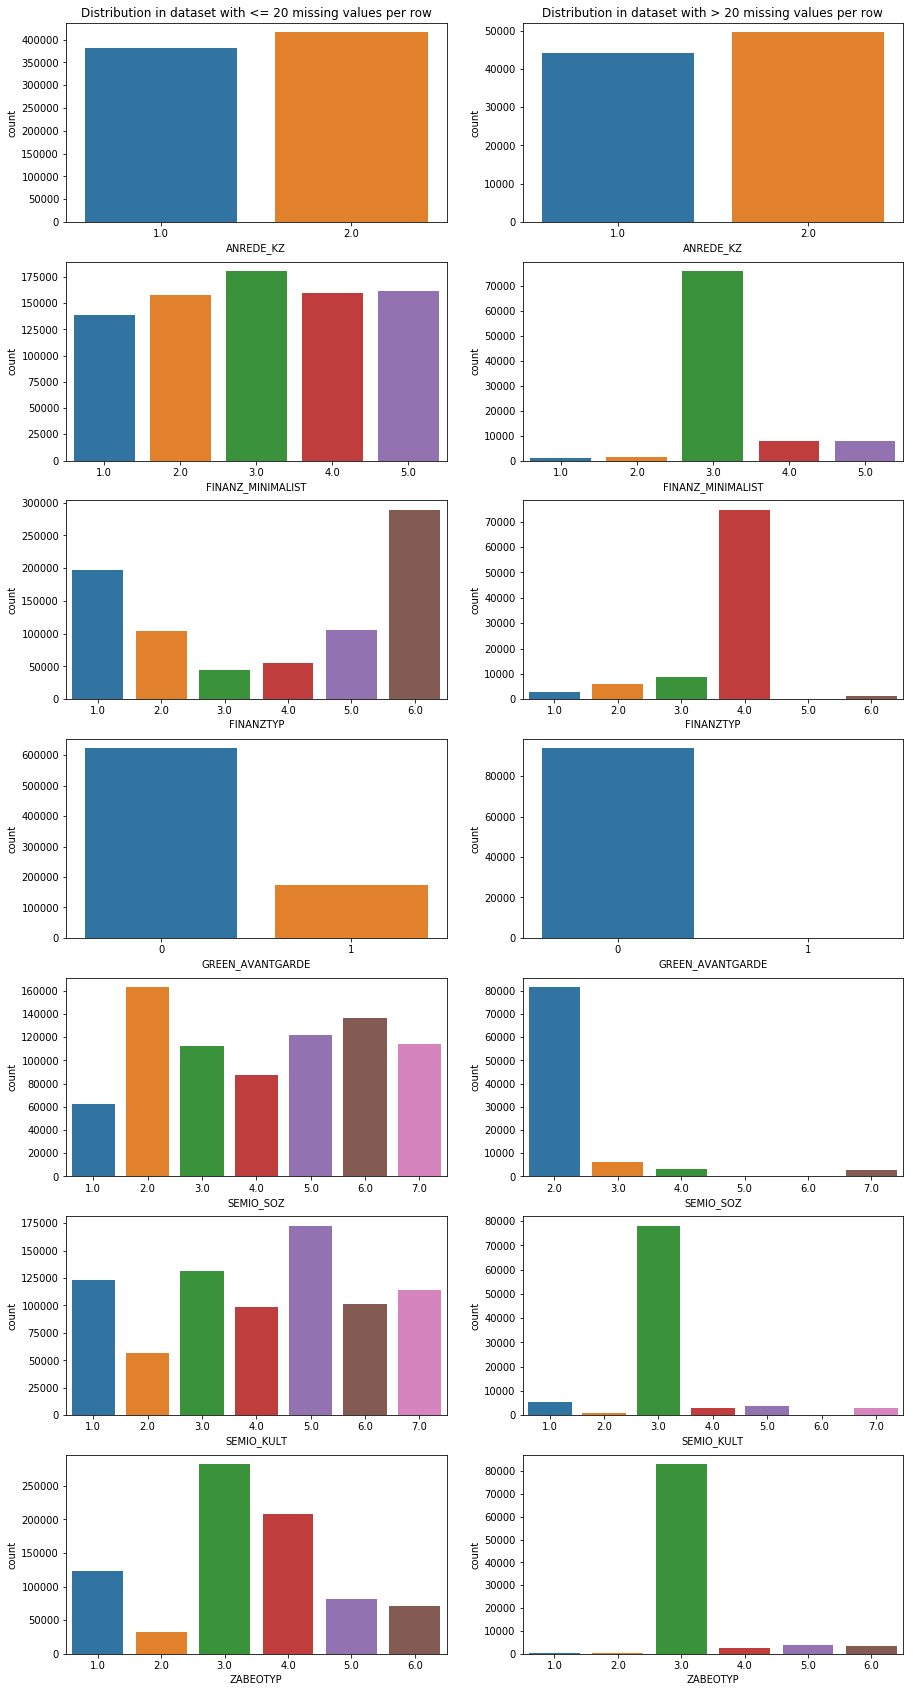

In [18]:
selected_columns = ['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZTYP', 'GREEN_AVANTGARDE', 'SEMIO_SOZ', 'SEMIO_KULT', 'ZABEOTYP']
compare_plots(selected_columns)

#### Discussion 1.1.3: Assess Missing Data in Each Row

We can see from the histogram of count of missing values per row, most of the rows have less than 20 missing values. So, I decided to take the threshold for dividing the dataset as 20.

From the comparison of distribution of values, we can see that some of the columns like ANREDE_KZ and GREEN_AVANTGARDE have similar distribution of values in both the subsets. However, the distribution of some of the columns like FINANZTYP and SEMIO_KULT look very different.

As instructed, I will continue my analysis using the subset of data with upto 20 missing values.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [19]:
# How many features are there of each data type?
#feat_info.groupby('type').count()
feat_info.groupby('type')['attribute'].count()

type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
Name: attribute, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [20]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categorical_features = feat_info[feat_info['type'] == 'categorical']['attribute'].values
categorical_features = [x for x in categorical_features if x in low_nan_subset.columns]
print('Feature \t No of categories \t Data Type \t Values')
for column in categorical_features:
    print(column, '\t', low_nan_subset[column].nunique(), '\t', low_nan_subset[column].dtype, '\t', low_nan_subset[column].unique())


Feature 	 No of categories 	 Data Type 	 Values
ANREDE_KZ 	 2 	 float64 	 [ 2.  1.]
CJT_GESAMTTYP 	 6 	 float64 	 [  5.   3.   2.   4.   1.   6.  nan]
FINANZTYP 	 6 	 float64 	 [ 1.  6.  5.  2.  4.  3.]
GFK_URLAUBERTYP 	 12 	 float64 	 [ 10.   1.   5.  12.   9.   3.   8.  11.   4.   2.   7.   6.  nan]
GREEN_AVANTGARDE 	 2 	 int64 	 [0 1]
LP_FAMILIE_FEIN 	 11 	 float64 	 [  5.   1.  nan  10.   2.   7.  11.   8.   4.   6.   9.   3.]
LP_FAMILIE_GROB 	 5 	 float64 	 [  3.   1.  nan   5.   2.   4.]
LP_STATUS_FEIN 	 10 	 float64 	 [  2.   3.   9.   4.   1.  10.   5.   8.   6.   7.  nan]
LP_STATUS_GROB 	 5 	 float64 	 [  1.   2.   4.   5.   3.  nan]
NATIONALITAET_KZ 	 3 	 float64 	 [  1.   3.   2.  nan]
SHOPPER_TYP 	 4 	 float64 	 [  3.   2.   1.   0.  nan]
SOHO_KZ 	 2 	 float64 	 [ 1.  0.]
VERS_TYP 	 2 	 float64 	 [  2.   1.  nan]
ZABEOTYP 	 6 	 float64 	 [ 5.  3.  4.  1.  6.  2.]
GEBAEUDETYP 	 7 	 float64 	 [ 8.  1.  3.  2.  6.  4.  5.]
OST_WEST_KZ 	 2 	 object 	 ['W' 'O']
CAMEO_DEUG_2015 	

In [21]:
numeric_binary = [x for x in categorical_features if (low_nan_subset[x].nunique()==2 and np.issubdtype(low_nan_subset[x].dtype, np.number))]
non_numeric_binary = [x for x in categorical_features if (low_nan_subset[x].nunique()==2 and not np.issubdtype(low_nan_subset[x].dtype, np.number))]
multilevel = [x for x in categorical_features if low_nan_subset[x].nunique() > 2]
print(numeric_binary)
print(non_numeric_binary)
print(multilevel)

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP']
['OST_WEST_KZ']
['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [22]:
# Re-encode categorical variable(s) to be kept in the analysis.

print(low_nan_subset.shape)

# Re-encoding non-numeric binary
low_nan_subset.loc[low_nan_subset['OST_WEST_KZ']=='W','OST_WEST_KZ'] = 0
low_nan_subset.loc[low_nan_subset['OST_WEST_KZ']=='O','OST_WEST_KZ'] = 1
#low_nan_subset['OST_WEST_KZ'] = low_nan_subset['OST_WEST_KZ'].apply(lambda x: 0 if x == 'W' else 1)

# Dropping multilevel variable CAMEO_DEU_2015
low_nan_subset.drop('CAMEO_DEU_2015', axis = 1, inplace=True)
multilevel.remove('CAMEO_DEU_2015')

# One-hot encoding remaining multilevel variables
low_nan_subset = pd.get_dummies(data=low_nan_subset, columns=multilevel)

print(low_nan_subset.shape)
print(list(low_nan_subset.columns))

(797426, 79)


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


(797426, 150)
['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PL

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

There are 4 binary categoricals that take numeric values. I have left them as it is.

There was only 1 binary categorical 'OST_WEST_KZ' that had non-numeric value.  I have re-encoded the values as numbers by replacing 'W' with 0 and 'O' with 1.

For multi-level categoricals, I decided to drop the feature 'CAMEO_DEU_2015' since it had 44 different possible values and one-hot encoding would have added 44 dummy variables. For the remaining of them, I have performed one-hot encoding using pd.get_dummies.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [23]:
mixed_features = feat_info[feat_info['type'] == 'mixed']['attribute'].values
mixed_features = [x for x in mixed_features if x in low_nan_subset.columns]
print('Mixed Features: {} \n'.format(mixed_features))
print('Feature \t No of options \t Data Type \t Values')
for column in mixed_features:
    print(column, '\t', low_nan_subset[column].nunique(), '\t', low_nan_subset[column].dtype, '\t', low_nan_subset[column].unique())


Mixed Features: ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX'] 

Feature 	 No of options 	 Data Type 	 Values
LP_LEBENSPHASE_FEIN 	 40 	 float64 	 [ 21.   3.  nan  32.   8.   2.   5.  10.   4.   6.  23.  12.  20.   1.  11.
  25.  13.  18.  31.  38.  35.  30.   7.  22.  14.  29.  24.  28.  37.  26.
  39.  27.  36.   9.  34.  33.  15.  40.  16.  19.  17.]
LP_LEBENSPHASE_GROB 	 12 	 float64 	 [  6.   1.  nan  10.   2.   3.   5.   7.  12.  11.   9.   4.   8.]
PRAEGENDE_JUGENDJAHRE 	 15 	 float64 	 [ 14.  15.   8.   3.  10.  11.   5.   9.   6.   4.  nan   2.   1.  12.  13.
   7.]
WOHNLAGE 	 8 	 float64 	 [ 4.  2.  7.  3.  5.  1.  8.  0.]
CAMEO_INTL_2015 	 21 	 object 	 ['51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' nan '25'
 '23' '31' '52' '35' '45' '44' '32']
PLZ8_BAUMAX 	 5 	 float64 	 [  1.   2.  nan   4.   5.   3.]


In [24]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
low_nan_subset.loc[low_nan_subset['PRAEGENDE_JUGENDJAHRE'].isin([1, 2]), 'PRAEGENDE_JUGENDJAHRE_DECADE'] = 0
low_nan_subset.loc[low_nan_subset['PRAEGENDE_JUGENDJAHRE'].isin([3, 4]), 'PRAEGENDE_JUGENDJAHRE_DECADE'] = 1
low_nan_subset.loc[low_nan_subset['PRAEGENDE_JUGENDJAHRE'].isin([5, 6, 7]), 'PRAEGENDE_JUGENDJAHRE_DECADE'] = 2
low_nan_subset.loc[low_nan_subset['PRAEGENDE_JUGENDJAHRE'].isin([8, 9]), 'PRAEGENDE_JUGENDJAHRE_DECADE'] = 3
low_nan_subset.loc[low_nan_subset['PRAEGENDE_JUGENDJAHRE'].isin([10, 11, 12, 13]), 'PRAEGENDE_JUGENDJAHRE_DECADE'] = 4
low_nan_subset.loc[low_nan_subset['PRAEGENDE_JUGENDJAHRE'].isin([14,15]), 'PRAEGENDE_JUGENDJAHRE_DECADE'] = 5

mainstream = [1, 3, 5, 8, 10, 12, 14]
avantgarde = [2, 4, 6, 7, 9, 11, 13, 15]
low_nan_subset.loc[low_nan_subset['PRAEGENDE_JUGENDJAHRE'].isin(mainstream), 'PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = 0
low_nan_subset.loc[low_nan_subset['PRAEGENDE_JUGENDJAHRE'].isin(avantgarde), 'PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = 1

low_nan_subset.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
mixed_features.remove('PRAEGENDE_JUGENDJAHRE')

In [25]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
low_nan_subset.loc[:, 'CAMEO_INTL_2015_WEALTH'] = low_nan_subset['CAMEO_INTL_2015'].apply(pd.to_numeric)//10
low_nan_subset.loc[:, 'CAMEO_INTL_2015_LIFESTAGE'] = low_nan_subset['CAMEO_INTL_2015'].apply(pd.to_numeric)%10
low_nan_subset.drop('CAMEO_INTL_2015', axis=1, inplace=True)
mixed_features.remove('CAMEO_INTL_2015')

In [26]:
# Dropping remaining mixed-type features
low_nan_subset.drop(mixed_features, axis=1, inplace=True)

print(low_nan_subset.shape)
print(list(low_nan_subset.columns))

(797426, 148)
['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEIT', 'ORTSGR_KLS9', 'RELAT_AB', 'CJT_GESAMTTYP_1.0', 'CJT_GESAMTTYP_2.0', 'CJT_GESAMTTYP_3.

#### Discussion 1.2.2: Engineer Mixed-Type Features

There are 6 mixed-type features in the reduced dataset.

As per the instructions, I have performed the handling of the features PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015.
I have replaced PRAEGENDE_JUGENDJAHRE with two new variables:
- an interval-type variable for decade, PRAEGENDE_JUGENDJAHRE_DECADE
- and a binary variable for movement, PRAEGENDE_JUGENDJAHRE_MOVEMENT

I have replaced CAMEO_INTL_2015 with two new ordinal variables:
- CAMEO_INTL_2015_WEALTH representing wealth
- CAMEO_INTL_2015_LIFESTAGE representing life stage.

The features LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB don't provide any new information. These informations are already present in other features (LP_FAMILIE_FEIN, LP_FAMILIE_GROB, LP_STATUS_FEIN, LP_STATUS_GROB) in a much simpler form. So I have dropped these 2 features.

The feature WOHNLAGE describes neighborhood quality in a very subjective manner (good neighborhood, average neighborhood, poor neighborhood etc). The definitions of good and bad differ from person to person, and from location to location. So, there could have been discrepancies even while collecting the data. Hence I have dropped this feature also.

The feature PLZ8_BAUMAX again doesn't provide any new information. The information is already available in other features (PLZ8_ANTG1, PLZ8_ANTG2, PLZ8_HHZ, PLZ8_GBZ etc). So I have dropped this one also.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [27]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)


In [28]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [157]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')
    
    # convert missing value codes into NaNs, ...
    for index, row in feat_info.iterrows():
        feature_name = row['attribute']
        temp_str = row['missing_or_unknown'].strip('[] ')
        temp_list = []
        if temp_str:
            temp_list = temp_str.split(',')
        missing_or_unknown_list = [ int(val.strip()) if val.strip(' -').isdigit() else val.strip() for val in temp_list ]
        if missing_or_unknown_list:
            df.loc[df[feature_name].isin(missing_or_unknown_list), feature_name] = np.nan
    
    # remove selected columns and rows, ...
    outlier_columns = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df.drop(outlier_columns, axis=1, inplace=True)
    
    nan_counts_per_row = df.isnull().sum(axis=1)
    low_nan_subset = df[nan_counts_per_row <= 20]
    
    # select, re-encode, and engineer column values.
    categorical_features = feat_info[feat_info['type'] == 'categorical']['attribute'].values
    categorical_features = [x for x in categorical_features if x in low_nan_subset.columns]
    multilevel = [x for x in categorical_features if low_nan_subset[x].nunique() > 2]
    low_nan_subset.loc[low_nan_subset['OST_WEST_KZ']=='W','OST_WEST_KZ'] = 0
    low_nan_subset.loc[low_nan_subset['OST_WEST_KZ']=='O','OST_WEST_KZ'] = 1
    low_nan_subset.drop('CAMEO_DEU_2015', axis = 1, inplace=True)
    multilevel.remove('CAMEO_DEU_2015')
    low_nan_subset = pd.get_dummies(data=low_nan_subset, columns=multilevel)
    
    mixed_features = feat_info[feat_info['type'] == 'mixed']['attribute'].values
    mixed_features = [x for x in mixed_features if x in low_nan_subset.columns]
    low_nan_subset.loc[low_nan_subset['PRAEGENDE_JUGENDJAHRE'].isin([1, 2]), 'PRAEGENDE_JUGENDJAHRE_DECADE'] = 0
    low_nan_subset.loc[low_nan_subset['PRAEGENDE_JUGENDJAHRE'].isin([3, 4]), 'PRAEGENDE_JUGENDJAHRE_DECADE'] = 1
    low_nan_subset.loc[low_nan_subset['PRAEGENDE_JUGENDJAHRE'].isin([5, 6, 7]), 'PRAEGENDE_JUGENDJAHRE_DECADE'] = 2
    low_nan_subset.loc[low_nan_subset['PRAEGENDE_JUGENDJAHRE'].isin([8, 9]), 'PRAEGENDE_JUGENDJAHRE_DECADE'] = 3
    low_nan_subset.loc[low_nan_subset['PRAEGENDE_JUGENDJAHRE'].isin([10, 11, 12, 13]), 'PRAEGENDE_JUGENDJAHRE_DECADE'] = 4
    low_nan_subset.loc[low_nan_subset['PRAEGENDE_JUGENDJAHRE'].isin([14,15]), 'PRAEGENDE_JUGENDJAHRE_DECADE'] = 5
    low_nan_subset.loc[low_nan_subset['PRAEGENDE_JUGENDJAHRE'].isin([1, 3, 5, 8, 10, 12, 14]), 'PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = 0
    low_nan_subset.loc[low_nan_subset['PRAEGENDE_JUGENDJAHRE'].isin([2, 4, 6, 7, 9, 11, 13, 15]), 'PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = 1
    low_nan_subset.loc[:, 'CAMEO_INTL_2015_WEALTH'] = low_nan_subset['CAMEO_INTL_2015'].apply(pd.to_numeric)//10
    low_nan_subset.loc[:, 'CAMEO_INTL_2015_LIFESTAGE'] = low_nan_subset['CAMEO_INTL_2015'].apply(pd.to_numeric)%10
    low_nan_subset.drop(mixed_features, axis=1, inplace=True)
    
    # Return the cleaned dataframe.
    return low_nan_subset
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [30]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

nan_counts_per_column = low_nan_subset.isnull().sum()
columns_with_nan = nan_counts_per_column[nan_counts_per_column > 0]
print('Feature \t No of categories \t Data Type \t Values')
for column in columns_with_nan.index:
    print(column, '\t', low_nan_subset[column].nunique(), '\t', low_nan_subset[column].dtype, '\t', low_nan_subset[column].unique())


Feature 	 No of categories 	 Data Type 	 Values
ALTERSKATEGORIE_GROB 	 4 	 float64 	 [  1.   3.   4.   2.  nan]
HEALTH_TYP 	 3 	 float64 	 [  3.   2.   1.  nan]
RETOURTYP_BK_S 	 5 	 float64 	 [  1.   3.   2.   5.   4.  nan]
VERS_TYP 	 2 	 float64 	 [  2.   1.  nan]
W_KEIT_KIND_HH 	 6 	 float64 	 [  3.  nan   2.   6.   5.   4.   1.]
ANZ_HAUSHALTE_AKTIV 	 291 	 float64 	 [  11.   10.    1.    3.    5.    4.    6.    2.    9.   nan   14.   13.
    8.    7.   44.   25.   36.   16.  272.   33.   15.   12.   22.   21.
   20.   67.   23.   18.   27.   24.   31.   39.   19.   30.   17.   29.
   61.   54.   88.   49.   60.   38.   34.   48.   35.   62.   26.   45.
   42.   28.   77.   47.   50.  236.  137.   43.   52.   41.   76.   63.
   32.   40.   37.   59.   53.   57.  118.   66.   95.   78.   70.   46.
  185.   73.  154.   80.  102.   92.  126.   94.   71.   68.   81.   69.
  121.  258.   58.   86.  124.   85.   90.  128.   51.   72.   64.   56.
   83.  150.  259.   91.  160.  134.  169.  

In [31]:
imputer = Imputer(missing_values=np.nan, strategy='median')
imputed_df = pd.DataFrame(imputer.fit_transform(low_nan_subset), columns=low_nan_subset.columns)

In [32]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(imputed_df), columns = imputed_df.columns)

### Discussion 2.1: Apply Feature Scaling

The dataset contains missing values only in numeric, ordinal, binary categoricals and engineered features from mixed-types.
The missing values in multi-level categoricals are already taken care of by one-hot encoding.

We can see all the columns with missing values contain integer values. So, to preserve the integer property in the imputed dataset, I decided to use 'median' strategy for my imputation.

Then I have used StandardScaler to standardize the data.

I didn't understand the statement:
"You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation."
It would be great if you could please explain.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [33]:
# Apply PCA to the data.
pca = PCA()
pca_transformed_data = pca.fit_transform(scaled_df)

In [34]:
def scree_plot(pca):
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

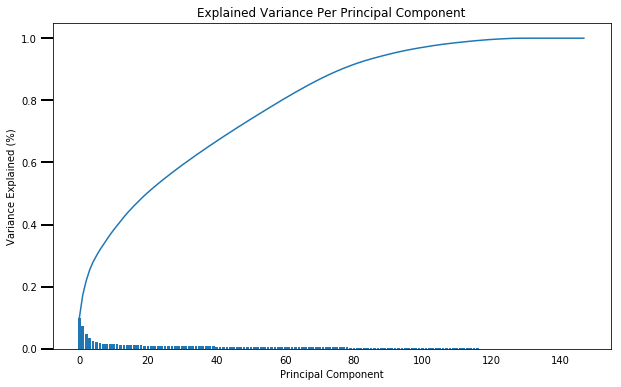

In [35]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca)

In [36]:
def decide_n_components(df):
    print('Total number of components in original data: {}'. format(df.shape[1]))
    for n_components in range(df.shape[1]//2, df.shape[1]):
        pca = PCA(n_components)
        transformed_data = pca.fit_transform(df)
        variance = pca.explained_variance_ratio_
        print("Using {} components, we can explain {}% of the variability in the original data.".format(n_components, variance.sum()))
        if variance.sum() >= 0.9:
            return pca, transformed_data
    return None

In [37]:
pca, transformed_data = decide_n_components(scaled_df)
print('Number of components selected: {}'.format(len(pca.components_)))

Total number of components in original data: 148
Using 74 components, we can explain 0.8834956800362629% of the variability in the original data.
Using 75 components, we can explain 0.8884627550713154% of the variability in the original data.
Using 76 components, we can explain 0.8933764453160273% of the variability in the original data.
Using 77 components, we can explain 0.8980160165068052% of the variability in the original data.
Using 78 components, we can explain 0.9027352936977058% of the variability in the original data.
Number of components selected: 78


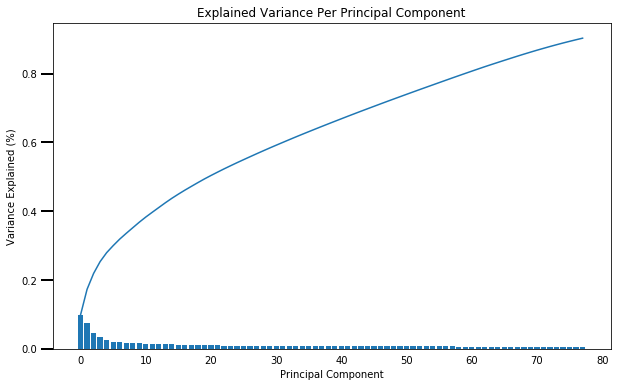

In [38]:
# Re-apply PCA to the data while selecting for number of components to retain.
final_pca = PCA(n_components=78)
final_transformed_data = final_pca.fit_transform(scaled_df)
scree_plot(final_pca)

### Discussion 2.2: Perform Dimensionality Reduction

We can explain 90% of the variability in original data by using 78 components out of the 148. Thus, I have chosen to retain 78 principal components.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [39]:
def print_sorted_weights_for_component(pca, columns, i):
    print("Sorted list of weights associated with component {}:".format(i))
    weights = {}
    for index, feature_name in enumerate(columns):
        weights[feature_name] = pca.components_[i][index]
    sorted_weights = sorted(weights.items(), key=lambda x: x[1], reverse=True)
    print("Feature \t\t Weight")
    for w in sorted_weights:
        print(w[0],'\t\t', w[1])

In [40]:
def get_all_weights_and_variance(pca, columns):
    principal_component_labels = ['Component {}'.format(i) for i in range(1, len(pca.components_)+1)]
    components = pd.DataFrame(np.round(pca.components_, 4), columns = columns)
    components.index = principal_component_labels
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = principal_component_labels
    return pd.concat([variance_ratios, components], axis = 1)

In [41]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

print_sorted_weights_for_component(final_pca, scaled_df.columns, 0)

Sorted list of weights associated with component 0:
Feature 		 Weight
LP_STATUS_GROB_1.0 		 0.200520600027
HH_EINKOMMEN_SCORE 		 0.187930760451
PLZ8_ANTG3 		 0.182648749438
CAMEO_INTL_2015_WEALTH 		 0.181934984817
PLZ8_ANTG4 		 0.177014044579
ORTSGR_KLS9 		 0.15654507924
EWDICHTE 		 0.155175697648
FINANZ_HAUSBAUER 		 0.150314473047
KBA05_ANTG4 		 0.131230666452
FINANZ_SPARER 		 0.127361283662
LP_STATUS_FEIN_1.0 		 0.126673304703
PLZ8_ANTG2 		 0.125337035887
LP_STATUS_FEIN_2.0 		 0.123219324349
FINANZTYP_1.0 		 0.122776899977
KBA05_ANTG3 		 0.119700247158
ANZ_HAUSHALTE_AKTIV 		 0.117221721792
ARBEIT 		 0.113744826421
CAMEO_DEUG_2015_9 		 0.112384587415
RELAT_AB 		 0.107844705885
SEMIO_PFLICHT 		 0.0943701183795
CAMEO_DEUG_2015_8 		 0.0905645362252
SEMIO_REL 		 0.0894058639254
LP_FAMILIE_FEIN_1.0 		 0.0879759352581
LP_FAMILIE_GROB_1.0 		 0.0879759352581
PRAEGENDE_JUGENDJAHRE_DECADE 		 0.0834538753697
ZABEOTYP_5.0 		 0.0819884152339
SEMIO_RAT 		 0.0790807167487
SEMIO_TRADV 		 0.0699510121

In [42]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print_sorted_weights_for_component(final_pca, scaled_df.columns, 1)

Sorted list of weights associated with component 1:
Feature 		 Weight
ALTERSKATEGORIE_GROB 		 0.229641119251
FINANZ_VORSORGER 		 0.215429204192
ZABEOTYP_3.0 		 0.2008941176
SEMIO_ERL 		 0.179633080505
SEMIO_LUST 		 0.161481378719
RETOURTYP_BK_S 		 0.156041132914
W_KEIT_KIND_HH 		 0.130778974581
CJT_GESAMTTYP_2.0 		 0.106434541456
LP_STATUS_FEIN_1.0 		 0.104443289131
FINANZTYP_5.0 		 0.0981691502781
FINANZ_HAUSBAUER 		 0.0965264607314
FINANZTYP_2.0 		 0.0880140098671
FINANZ_MINIMALIST 		 0.0760298681688
SEMIO_KRIT 		 0.075461626008
PLZ8_ANTG3 		 0.0743252208052
EWDICHTE 		 0.0728362724936
SHOPPER_TYP_3.0 		 0.0720293722593
ORTSGR_KLS9 		 0.0717492178348
PLZ8_ANTG4 		 0.0705495397825
CJT_GESAMTTYP_1.0 		 0.0699625848058
CAMEO_INTL_2015_WEALTH 		 0.0671453165402
FINANZTYP_6.0 		 0.0661209998829
LP_FAMILIE_FEIN_1.0 		 0.0657564525254
LP_FAMILIE_GROB_1.0 		 0.0657564525254
NATIONALITAET_KZ_1.0 		 0.0619252092547
SEMIO_KAEM 		 0.0616935646046
KBA05_ANTG4 		 0.0602746011333
GFK_URLAUBERTYP_4.

In [43]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print_sorted_weights_for_component(final_pca, scaled_df.columns, 2)

Sorted list of weights associated with component 2:
Feature 		 Weight
SEMIO_VERT 		 0.319859361672
SEMIO_FAM 		 0.261701211139
SEMIO_SOZ 		 0.257774289554
SEMIO_KULT 		 0.252482668278
FINANZTYP_5.0 		 0.135175646536
FINANZ_MINIMALIST 		 0.127042255439
SHOPPER_TYP_0.0 		 0.123133151307
ZABEOTYP_1.0 		 0.113707238295
SEMIO_REL 		 0.113145458609
SEMIO_MAT 		 0.0891742104804
RETOURTYP_BK_S 		 0.076435339795
W_KEIT_KIND_HH 		 0.0710494914653
PRAEGENDE_JUGENDJAHRE_MOVEMENT 		 0.0682944711393
GREEN_AVANTGARDE 		 0.0682944711393
ORTSGR_KLS9 		 0.0624618516135
EWDICHTE 		 0.0622578290372
SHOPPER_TYP_1.0 		 0.0550315058132
ZABEOTYP_6.0 		 0.0511068738161
PLZ8_ANTG4 		 0.0499534221798
PLZ8_ANTG3 		 0.0498623849853
FINANZ_VORSORGER 		 0.0482789131144
LP_STATUS_FEIN_10.0 		 0.0467745230482
LP_STATUS_GROB_5.0 		 0.0467745230482
LP_STATUS_FEIN_1.0 		 0.046543118793
LP_STATUS_FEIN_3.0 		 0.0449428394047
PLZ8_ANTG2 		 0.0361500427055
RELAT_AB 		 0.0356675373971
ARBEIT 		 0.0347408389728
GEBAEUDETYP_3.0

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)


**First component:**

The features giving highest positive weights:  
- LP_STATUS_GROB_1.0 : Social status, rough scale
- HH_EINKOMMEN_SCORE : Estimated household net income
- PLZ8_ANTG3 : Number of 6-10 family houses in the PLZ8 region
- CAMEO_INTL_2015_WEALTH : Wealth
- PLZ8_ANTG4 : Number of 10+ family houses in the PLZ8 region
- ORTSGR_KLS9: Size of community
- EWDICHTE : Density of households per square kilometer
- FINANZ_HAUSBAUER : Financial typology
- KBA05_ANTG4 : Number of 10+ family houses in the microcell

The features giving lowest negative weights:
- MOBI_REGIO : Movement patterns
- FINANZ_MINIMALIST : Financial typology low financial interest
- KBA05_ANTG1 : Number of 1-2 family houses in the microcell
- PLZ8_ANTG1 : Number of 1-2 family houses in the PLZ8 region
- KBA05_GBZ : Number of buildings in the microcell

We can see the positive weighted features for this component are mostly about the social status, income, neighbourhood and financial status. Whereas the negative weighted features are about movement patterns, financial status and neighbourhood. This also seems logically correct as in real life also, these features are usually highly related. People with higher income have higher wealth and social status. People having similar wealth tend to live in same neighborhood. Also, wealthy neighbourhood has less houses and less movement.
So, this component predominantly helps in identifying the wealth and neighbourhood of an individual.


**Second component:**

The features giving highest positive weights:  
- ALTERSKATEGORIE_GROB : Estimated age based on given name analysis
- FINANZ_VORSORGER : Financial typology
- ZABEOTYP_3.0 : Energy consumption typology
- SEMIO_ERL : Personality typology
- RETOURTYP_BK_S : Return type
- W_KEIT_KIND_HH : Likelihood of children in household

The features giving lowest negative weights:
- PRAEGENDE_JUGENDJAHRE_DECADE : decade
- FINANZ_SPARER, FINANZ_UNAUFFAELLIGER : Financial typology
- SEMIO_REL : Personality typology
- ONLINE_AFFINITAET : Online affinity

We can see that both the postive and negative features for this component are about age, financial and personality typology. The lowest negative feature 'decade' is a re-engineered feature which is inversely proportional to age (People born in 40s have value 0). Similarly, other personality and financial status variables must also be inversely proportional.
So, this component helps in identifying the age, personality and financial status of an individual.


**Third component:**

The features giving highest positive weights:  
- SEMIO_VERT, SEMIO_FAM, SEMIO_SOZ, SEMIO_KULT, SEMIO_REL : Personality typology
- FINANZTYP_5.0 : financial type for individual
- SHOPPER_TYP_0 : Shopper typology
- ZABEOTYP : Energy consumption typology

The features giving lowest negative weights:
- ANREDE_KZ : Gender
- SEMIO_KAEM, SEMIO_DOM, SEMIO_KRIT, SEMIO_ERL, SEMIO_RAT : Personality typology
- FINANZ_ANLEGER, FINANZTYP_1.0 : Financial Typology

We can see the positive weighted features for this component are mostly about personality, financial status and shopping habit. Whereas the negative weighted features are about gender and personality. This also seems logically correct as in real life also, each gender has specific personality traits and shopping habits.
So, this component predominantly helps in identifying the gender and personality of an individual.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [44]:
# Over a number of different cluster counts, run k-means clustering on the data
# and compute the average within-cluster distances.
    
sse_list = []
n_clusters_list = list(range(2,30))

for n in n_clusters_list:
    kmeans = MiniBatchKMeans(n_clusters=n)
    model = kmeans.fit(final_transformed_data)
    sse_score = np.abs(model.score(final_transformed_data))
    sse_list.append(sse_score)
    
    #predictions = model.predict(final_transformed_data)
    #slh_score = silhouette_score(final_transformed_data, predictions)
    #silhoutte_scores_list.append(slh_score)
    print("For n_clusters = {}, sse = {}".format(n, sse_score))

For n_clusters = 2, sse = 98110593.39925799
For n_clusters = 3, sse = 93164214.84615
For n_clusters = 4, sse = 91095309.1391983
For n_clusters = 5, sse = 88249359.84047271
For n_clusters = 6, sse = 86949738.04967704
For n_clusters = 7, sse = 86511069.95555018
For n_clusters = 8, sse = 86670084.35571943
For n_clusters = 9, sse = 85065477.79709713
For n_clusters = 10, sse = 84470690.59881338
For n_clusters = 11, sse = 81547161.17338501
For n_clusters = 12, sse = 81207810.68872833
For n_clusters = 13, sse = 81893735.77943438
For n_clusters = 14, sse = 81423348.79982254
For n_clusters = 15, sse = 78539271.05467655
For n_clusters = 16, sse = 77496037.09106168
For n_clusters = 17, sse = 76932723.0726567
For n_clusters = 18, sse = 80339973.15638721
For n_clusters = 19, sse = 77411933.16350408
For n_clusters = 20, sse = 79872906.50653929
For n_clusters = 21, sse = 74131285.32291877
For n_clusters = 22, sse = 75107335.88345683
For n_clusters = 23, sse = 73228576.76149853
For n_clusters = 24, ss

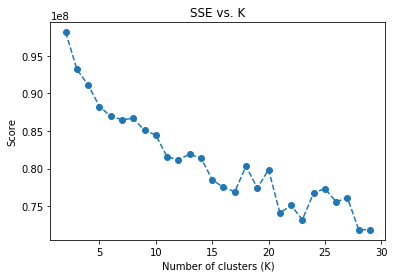

In [45]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(n_clusters_list, sse_list, linestyle='--', marker='o');
plt.xlabel('Number of clusters (K)');
plt.ylabel('Score');
plt.title('SSE vs. K');

In [127]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

n_clusters=17
final_kmeans = KMeans(n_clusters=n_clusters).fit(final_transformed_data)
demographics_predictions = final_kmeans.predict(final_transformed_data)

### Discussion 3.1: Apply Clustering to General Population

Since KMeans takes quite a lot of time, I have used MiniBatchKMeans to speed up the decision process.
We can see from the plot of average distance, that there is no such elbow in the graph. The average distance generally decreases till 17 clusters. After that the graph starts to fluctuate a lot. Also, since I have used MiniBatchKMeans, the results are usually little different each time. However, the general tendency is to decrease till 15-17 clusters, after which fluctuation starts. So I have decided to continue with 17 clusters.

Finally, I have used KMeans to perform the final clustering.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [161]:
'''data = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')
data = clean_data(data) 
print(data.shape) #(797426, 148)
new_imputer = Imputer(missing_values=np.nan, strategy='median')
data = pd.DataFrame(new_imputer.fit_transform(data), columns=data.columns)
new_scaler = StandardScaler()
scaled_data = pd.DataFrame(new_scaler.fit_transform(data), columns = data.columns)
new_pca = PCA(n_components=78)
new_data = new_pca.fit_transform(scaled_data)
new_kmeans = KMeans(n_clusters=17)
new_model = new_kmeans.fit(new_data)
new_predictions = new_model.predict(new_data)'''
pass

In [162]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [163]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers = clean_data(customers)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [164]:
# Add missing columns
missing_columns = set(low_nan_subset.columns) - set(customers.columns)
print(missing_columns)
# The missing column is because of the missing value 5.0 in the categorical variable GEBAEUDETYP
# So we just add the column with all rows being 0. 
for col in missing_columns:
    customers[col] = 0
    
# Check extra columns
extra_columns = set(customers.columns) - set(low_nan_subset.columns)
print(extra_columns)

# Re-order columns
customers = customers[low_nan_subset.columns]

{'GEBAEUDETYP_5.0'}
set()


In [165]:
customers = pd.DataFrame(imputer.transform(customers), columns=customers.columns)
scaled_customers = pd.DataFrame(scaler.transform(customers), columns=customers.columns)
customers_pca = final_pca.transform(scaled_customers)
customers_predictions = final_kmeans.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5,0,'Cluster Index')

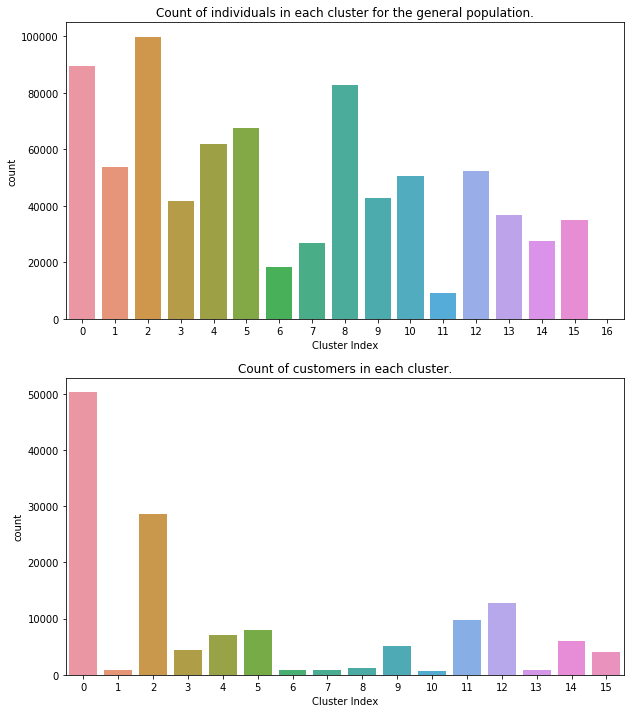

In [166]:
'''
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 12))
ax1.set_title('Percentage of individuals in each cluster for the general population.')
ax2.set_title('Percentage of customers in each cluster.')
demo_pred_pd=pd.DataFrame(demographics_predictions, columns=['clusters'])
cust_pred_pd=pd.DataFrame(customers_predictions, columns=['clusters'])
sns.barplot(x='clusters', y='clusters', data=demo_pred_pd, ax=ax1, estimator=lambda x: len(x) / len(demo_pred_pd) * 100)
ax1.set(ylabel="Percentage", xlabel='Cluster Index')
sns.barplot(x='clusters', y='clusters', data=cust_pred_pd, ax=ax2, estimator=lambda x: len(x) / len(cust_pred_pd) * 100)
ax2.set(ylabel="Percentage", xlabel='Cluster Index')
'''

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 12))
ax1.set_title('Count of individuals in each cluster for the general population.')
sns.countplot(demographics_predictions, ax=ax1)
ax1.set_xlabel('Cluster Index')
ax2.set_title('Count of customers in each cluster.')
sns.countplot(customers_predictions, ax=ax2)
ax2.set_xlabel('Cluster Index')



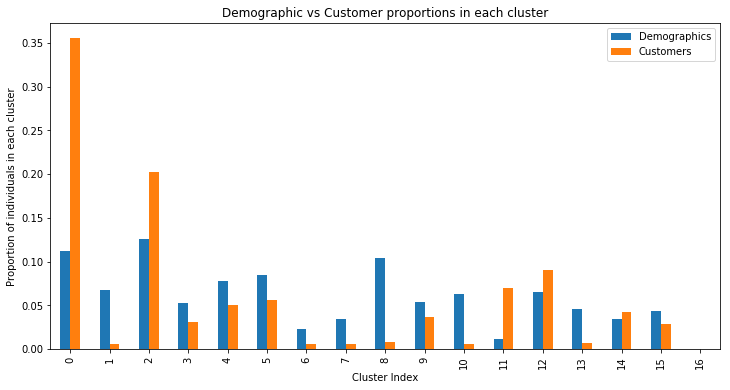

In [167]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

demographics_proportion = []
customers_proportion = []
for i in range(n_clusters):
    demographics_proportion.append((demographics_predictions == i).sum()/len(demographics_predictions))
    customers_proportion.append((customers_predictions == i).sum()/len(customers_predictions))

temp_df = pd.DataFrame({'Cluster Index' : range(n_clusters), 'Demographics' : demographics_proportion,
                        'Customers': customers_proportion})
temp_df.plot(x='Cluster Index', y = ['Demographics', 'Customers'], kind='bar', figsize=(12,6))
plt.title("Demographic vs Customer proportions in each cluster")
plt.ylabel('Proportion of individuals in each cluster')
plt.show()


In [168]:

cluster_features = pd.DataFrame(scaler.inverse_transform(final_pca.inverse_transform(final_kmeans.cluster_centers_)),
                             columns=low_nan_subset.columns)

In [169]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Clusters overrepresented in customer data are 0, 2, 11, 12
# We will check for cluster 0

for feature in cluster_features.loc[0].to_dict().items():
    print(feature[0],'\t\t', feature[1])

ALTERSKATEGORIE_GROB 		 3.35670879712
ANREDE_KZ 		 1.5029395766
FINANZ_MINIMALIST 		 4.58683582088
FINANZ_SPARER 		 1.59190505412
FINANZ_VORSORGER 		 4.28706832716
FINANZ_ANLEGER 		 1.83762654357
FINANZ_UNAUFFAELLIGER 		 2.06680914713
FINANZ_HAUSBAUER 		 2.09816267034
GREEN_AVANTGARDE 		 1.00350369049
HEALTH_TYP 		 2.10227706442
RETOURTYP_BK_S 		 3.82211597505
SEMIO_SOZ 		 3.9926407065
SEMIO_FAM 		 3.41719257687
SEMIO_REL 		 2.97949659789
SEMIO_MAT 		 3.08317726283
SEMIO_VERT 		 4.66048617766
SEMIO_LUST 		 5.18878851819
SEMIO_ERL 		 5.17498767216
SEMIO_KULT 		 3.52288476296
SEMIO_RAT 		 3.16109881881
SEMIO_KRIT 		 4.38425932595
SEMIO_DOM 		 4.68876063905
SEMIO_KAEM 		 4.23840371934
SEMIO_PFLICHT 		 3.19137351693
SEMIO_TRADV 		 3.02943648496
SOHO_KZ 		 0.00772882564296
VERS_TYP 		 1.48481292772
ANZ_PERSONEN 		 2.19372730907
ANZ_TITEL 		 -0.00142624038912
HH_EINKOMMEN_SCORE 		 2.33332905477
W_KEIT_KIND_HH 		 4.08171603647
WOHNDAUER_2008 		 8.58102307312
ANZ_HAUSHALTE_AKTIV 		 1.404589914

In [170]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Clusters underrepresented in customer data are 8, 1 , 10, 13 etc
# We will check for cluster cluster 8

for feature in cluster_features.loc[8].to_dict().items():
    print(feature[0],'\t\t', feature[1])

ALTERSKATEGORIE_GROB 		 1.79151207891
ANREDE_KZ 		 1.98376485663
FINANZ_MINIMALIST 		 1.05791812392
FINANZ_SPARER 		 4.49791035471
FINANZ_VORSORGER 		 2.18521189251
FINANZ_ANLEGER 		 4.41217097655
FINANZ_UNAUFFAELLIGER 		 3.8441102971
FINANZ_HAUSBAUER 		 4.39933786217
GREEN_AVANTGARDE 		 0.033445933047
HEALTH_TYP 		 2.15485105987
RETOURTYP_BK_S 		 2.67993665474
SEMIO_SOZ 		 3.26411458782
SEMIO_FAM 		 3.95686191715
SEMIO_REL 		 5.42507749629
SEMIO_MAT 		 4.69823742091
SEMIO_VERT 		 2.2573346207
SEMIO_LUST 		 3.31974346305
SEMIO_ERL 		 4.37681495393
SEMIO_KULT 		 4.11089033076
SEMIO_RAT 		 5.97879691579
SEMIO_KRIT 		 5.40512455073
SEMIO_DOM 		 6.02117198756
SEMIO_KAEM 		 6.07127517159
SEMIO_PFLICHT 		 6.10438361943
SEMIO_TRADV 		 5.33524944691
SOHO_KZ 		 0.00727252484238
VERS_TYP 		 1.57805840283
ANZ_PERSONEN 		 1.45050868307
ANZ_TITEL 		 0.00034286905566
HH_EINKOMMEN_SCORE 		 5.64386336606
W_KEIT_KIND_HH 		 4.05717669211
WOHNDAUER_2008 		 7.22560224828
ANZ_HAUSHALTE_AKTIV 		 14.58041900

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

Clusters overrepresented in customer data are 0, 2, 11, 12. I have analysed cluster 0.

Cluster 0 represents individuals who are about 46-60 years old (ALTERSKATEGORIE_GROB - 3.35) with very high household income (HH_EINKOMMEN_SCORE - 2.33). They are high money-saver (FINANZ_SPARER - 1.59), high investor(FINANZ_ANLEGER - 1.83), have low financial interest (FINANZ_MINIMALIST - 4.58) and high home ownership (FINANZ_HAUSBAUER - 2.09). They are also more likely to be member of green avantgarde (GREEN_AVANTGARDE - 1.00) and have health type as sanitary affine (HEALTH_TYP - 2.1). They are also more likely to be materialistic, religious and family-minded (SEMIO_FAM - 3.41719257687, SEMIO_REL - 2.979, SEMIO_MAT - 3.08). They are staying in their residence for more than 10 years (WOHNDAUER_2008 - 8.58) and their building was first mentioned in the database in 1993 (MIN_GEBAEUDEJAHR - 1992.93). The number of households in the building is very low (ANZ_HAUSHALTE_AKTIV - 1.4).


Clusters underrepresented in customer data are 8, 1 , 10, 13 etc. I have analysed cluster 8.

Cluster 8 represents females who are 30 to 45 years old (ALTERSKATEGORIE_GROB - 1.79) with very low household income (HH_EINKOMMEN_SCORE - 5.64). They are low money-saver (FINANZ_SPARER - 4.49) and have very high financial interest (FINANZ_MINIMALIST - 1.05). They have low investments (FINANZ_ANLEGER - 4.41) and low home ownership (FINANZ_HAUSBAUER - 4.39). They are not members of green avantgarde (GREEN_AVANTGARDE - 0.03). They are also more likely to be dreamful, sensual-minded and show very low affinity towards their duties (SEMIO_VERT - 2.25, SEMIO_LUST - 3.31, SEMIO_PFLICHT - 6.1). They stay in lower middle class neighbourhood (REGIOTYP - 5.0) with very high number of households in the building (ANZ_HAUSHALTE_AKTIV - 14.58).


So we can see that the company is more popular among wealthy middle-aged customers. And relatively unpopular with middle-aged lower middle class females.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.